## IMPORTS

In [28]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit
from qiskit import assemble, transpile
from torchsummary import summary

from itertools import combinations
DEVICE = torch.device('cpu')

## MNIST DATA

In [29]:
n_train = 200   
n_test = 300 

train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
idx = np.append(np.where(train_dataset.targets == 0)[0][:n_train], 
                np.where(train_dataset.targets == 1)[0][:n_train])

for i in range(2, 10):
    idx = np.append(idx, np.where(train_dataset.targets == i)[0][:n_train])
    
train_dataset.data    = train_dataset.data[idx]
train_dataset.targets = train_dataset.targets[idx]

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

idx = np.append(np.where(test_dataset.targets == 0)[0][:n_test], 
                np.where(test_dataset.targets == 1)[0][:n_test])

for i in range(2, 10):
    idx = np.append(idx, np.where(test_dataset.targets == i)[0][:n_test])
    
test_dataset.data    = test_dataset.data[idx]
test_dataset.targets = test_dataset.targets[idx]



In [30]:
BATCH_SIZE = 10

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

## TRAINING FUNCTION 

In [31]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=10, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history


## CNN

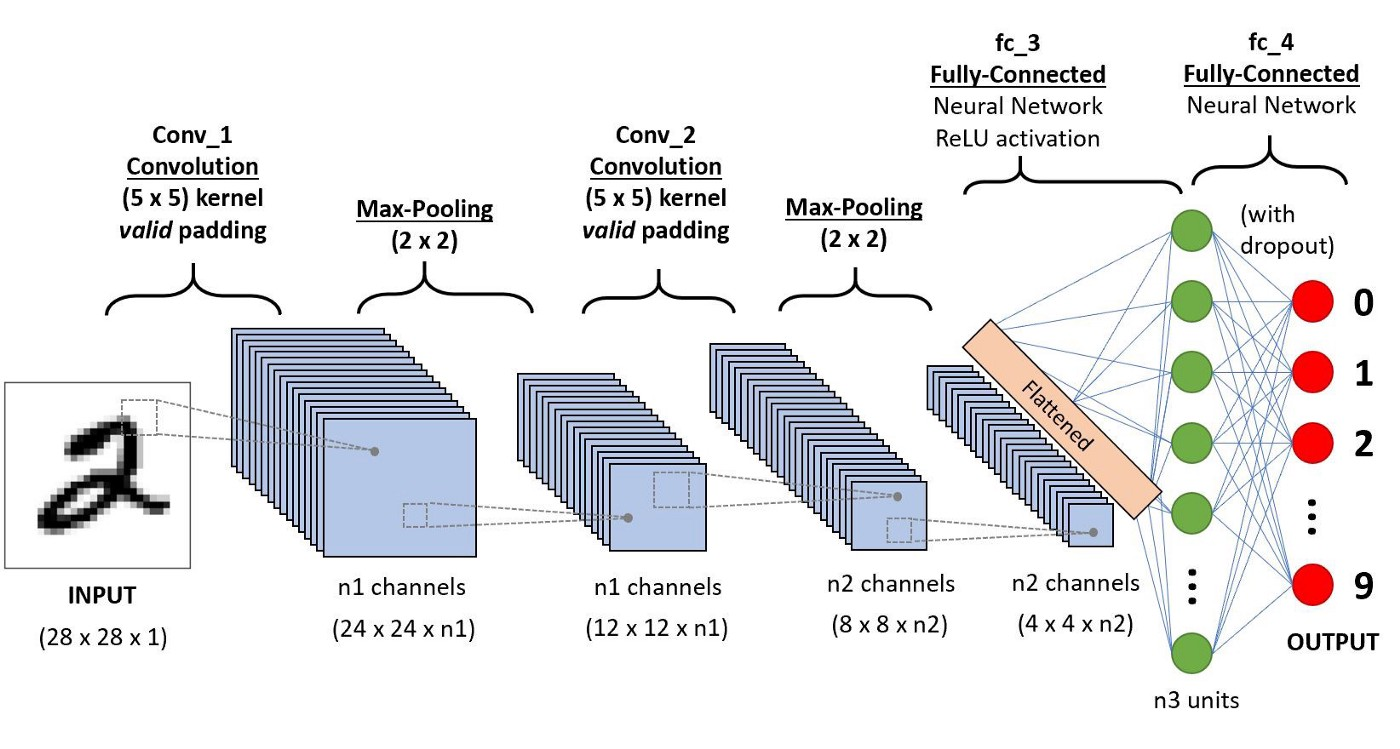

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
model1 = Net()
optimizer  = optim.Adam(model1.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [33]:
history1 = train(
    model = model1,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=50)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=50, device=cpu

Epoch   1/ 50, train loss:  1.44, train acc:  0.53, val loss:  0.57, val acc:  0.84
Epoch   2/ 50, train loss:  0.50, train acc:  0.86, val loss:  0.40, val acc:  0.88
Epoch   3/ 50, train loss:  0.36, train acc:  0.90, val loss:  0.33, val acc:  0.90
Epoch   4/ 50, train loss:  0.30, train acc:  0.91, val loss:  0.28, val acc:  0.91
Epoch   5/ 50, train loss:  0.28, train acc:  0.92, val loss:  0.33, val acc:  0.90
Epoch   6/ 50, train loss:  0.24, train acc:  0.93, val loss:  0.28, val acc:  0.92
Epoch   7/ 50, train loss:  0.22, train acc:  0.93, val loss:  0.26, val acc:  0.91
Epoch   8/ 50, train loss:  0.21, train acc:  0.94, val loss:  0.24, val acc:  0.93
Epoch   9/ 50, train loss:  0.19, train acc:  0.95, val loss:  0.23, val acc:  0.93
Epoch  10/ 50, train loss:  0.18, train acc:  0.95, val loss:  0.27, val acc:  0.92
Epoch  11/ 50, train loss:  0.17, train acc:  0.95, val loss:  0.24, val acc:  0.93
Epo

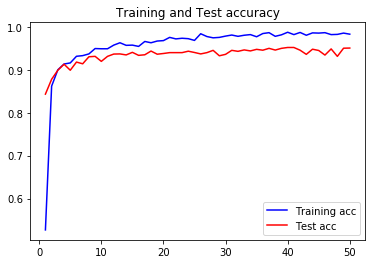

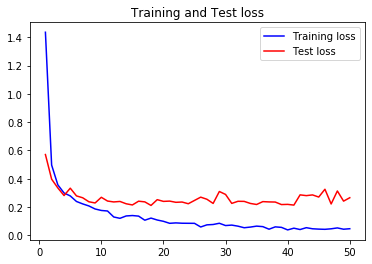

In [56]:
acc = history1['acc']
val_acc = history1['val_acc']
loss = history1['loss']
val_loss = history1['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## CNN + QUANTUM LAYER (10 circuits 1 qubit)

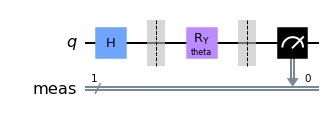

In [103]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        self._circuit = transpile(self._circuit, backend)
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        qobj = assemble(self._circuit,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
x =  QuantumCircuit(1, backend = Aer.get_backend('aer_simulator'), shots=  100)
x._circuit.draw(output='mpl')

In [36]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z)
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        
        gradients = torch.tensor([gradients])
        gradients = torch.transpose(gradients, 0, 1)
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.chunk(x, 10, dim=1)
        x = tuple([h(xx) for h, xx in zip(self.hybrid, x)])
        return torch.cat(x, -1)
model2 = Net()
optimizer  = optim.Adam(model2.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [38]:
history2 = train(
    model = model2,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=50)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=50, device=cpu

Epoch   1/ 50, train loss:  2.08, train acc:  0.38, val loss:  1.79, val acc:  0.76
Epoch   2/ 50, train loss:  1.78, train acc:  0.77, val loss:  1.71, val acc:  0.83
Epoch   3/ 50, train loss:  1.72, train acc:  0.85, val loss:  1.67, val acc:  0.90
Epoch   4/ 50, train loss:  1.70, train acc:  0.88, val loss:  1.65, val acc:  0.91
Epoch   5/ 50, train loss:  1.67, train acc:  0.90, val loss:  1.62, val acc:  0.91
Epoch   6/ 50, train loss:  1.66, train acc:  0.92, val loss:  1.63, val acc:  0.92
Epoch   7/ 50, train loss:  1.64, train acc:  0.94, val loss:  1.60, val acc:  0.93
Epoch   8/ 50, train loss:  1.63, train acc:  0.94, val loss:  1.60, val acc:  0.93
Epoch   9/ 50, train loss:  1.62, train acc:  0.95, val loss:  1.60, val acc:  0.93
Epoch  10/ 50, train loss:  1.62, train acc:  0.95, val loss:  1.59, val acc:  0.93
Epoch  11/ 50, train loss:  1.61, train acc:  0.95, val loss:  1.59, val acc:  0.94
Epo

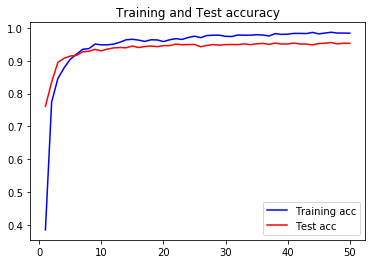

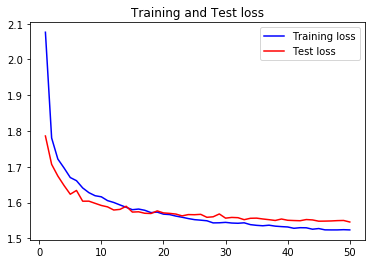

In [55]:
acc = history2['acc']
val_acc = history2['val_acc']
loss = history2['loss']
val_loss = history2['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## COMPARING TO CNN

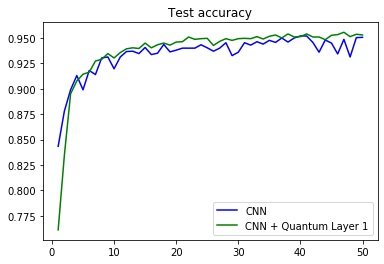

In [47]:
import matplotlib.pyplot as plt

acc1 = history1['val_acc']
acc2 = history2['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'b', label='CNN')
plt.plot(epochs, acc2, 'g', label='CNN + Quantum Layer 1')
plt.title('Test accuracy')
plt.legend()
plt.show()

## ANOTHER METHOD (1 circuit 4 qubits)

In [41]:
nombre_qubits = 4
nombre_shots = 1000
valeur_shift = np.pi/4
simulateur = Aer.get_backend('qasm_simulator')

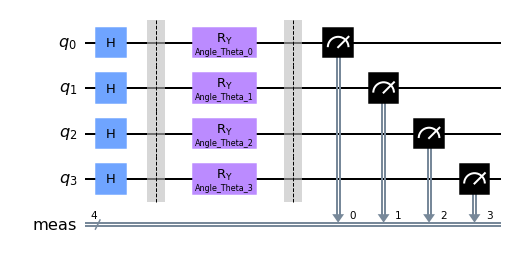

In [101]:
class QuantumCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        
        self.n_qubits = n_qubits
        
        self.circuit = qiskit.QuantumCircuit(self.n_qubits)
        
        self.name_thetas ={j : qiskit.circuit.Parameter('Angle_Theta_'+str(j))for j in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        
        self.circuit.barrier()
        
        for i in range(self.n_qubits): 
            self.circuit.ry(self.name_thetas[i], i)
        self.circuit = transpile(self.circuit, backend)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
       
        self.shots = shots
        
        self.output_states = []
    

        self.output_states = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001']        
        
    def run(self, thetas):
        qobj = assemble(self.circuit,
                shots=self.shots,
                parameter_binds = [{self.name_thetas[i]: thetas[i] for i in range(self.n_qubits)}])
        job = self.backend.run(qobj)
        counts = job.result().get_counts()
        expectation_z = np.zeros(10)
        for i in range(len(self.output_states)):
            expectation_z[i] = counts.get(self.output_states[i], 0)
           
        return np.array(expectation_z)
x =  QuantumCircuit(4, backend = Aer.get_backend('aer_simulator'), shots=  100)
x.circuit.draw(output='mpl')

In [43]:
class HybridFunction(Function):    

    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        ctx.quantum_circuit = quantum_circuit
        ctx.shift = shift

        expectation_z = []
        for input in inputs:
            expectation_z.append(quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z)
        ctx.save_for_backward(inputs, result)
        
        return result
    @staticmethod
    def backward(ctx, grad_output):
        inputs, expectation_z = ctx.saved_tensors
        input_numbers = inputs.tolist()
        gr = torch.Tensor()
        for i in range(len(input_numbers)):
            g = grad_output[i].reshape(1,10)
            gs = torch.Tensor()
            for k in range(nombre_qubits):
                shift_right = input_numbers[i].copy()
                shift_right[k] += valeur_shift
                shift_left = input_numbers[i].copy()
                shift_left[k]  -= valeur_shift
                expectation_right = ctx.quantum_circuit.run(shift_right)
                expectation_left  = ctx.quantum_circuit.run(shift_left)
                gradient = (torch.tensor([expectation_right]) - torch.tensor([expectation_left])).T
                gs = torch.cat((gs, gradient.float()), 1)
            gr = torch.cat((gr, g.float() @ gs.float()))
        return gr, None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(nombre_qubits, simulateur, nombre_shots)
        self.shift = np.pi/4
        
    def forward(self, inputs):
        return HybridFunction.apply(inputs, self.quantum_circuit, self.shift)

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 4)
        self.hybrid = Hybrid(simulateur, 100, np.pi / 4)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return F.log_softmax(x, dim=-1)
    
model3 = Net()
optimizer  = optim.Adam(model3.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [45]:
history3 = train(
    model = model3,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=50)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=50, device=cpu

Epoch   1/ 50, train loss: 10.58, train acc:  0.22, val loss:  7.73, val acc:  0.42
Epoch   2/ 50, train loss:  6.88, train acc:  0.47, val loss:  5.25, val acc:  0.56
Epoch   3/ 50, train loss:  5.53, train acc:  0.58, val loss:  5.79, val acc:  0.59
Epoch   4/ 50, train loss:  4.34, train acc:  0.68, val loss:  4.67, val acc:  0.66
Epoch   5/ 50, train loss:  4.27, train acc:  0.70, val loss:  3.63, val acc:  0.75
Epoch   6/ 50, train loss:  3.67, train acc:  0.75, val loss:  3.23, val acc:  0.78
Epoch   7/ 50, train loss:  2.92, train acc:  0.79, val loss:  3.09, val acc:  0.77
Epoch   8/ 50, train loss:  2.62, train acc:  0.81, val loss:  3.04, val acc:  0.77
Epoch   9/ 50, train loss:  2.65, train acc:  0.81, val loss:  2.78, val acc:  0.82
Epoch  10/ 50, train loss:  2.27, train acc:  0.84, val loss:  2.72, val acc:  0.83
Epoch  11/ 50, train loss:  2.17, train acc:  0.84, val loss:  2.69, val acc:  0.83
Epo

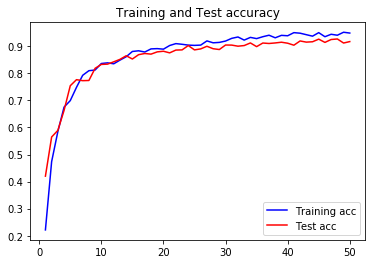

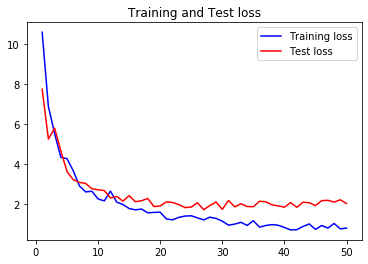

In [54]:
import matplotlib.pyplot as plt

acc = history3['acc']
val_acc = history3['val_acc']
loss = history3['loss']
val_loss = history3['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## COMPARING TO CNN

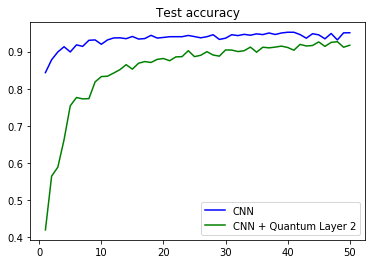

In [48]:
import matplotlib.pyplot as plt

acc1 = history1['val_acc']
acc2 = history3['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'b', label='CNN')
plt.plot(epochs, acc2, 'g', label='CNN + Quantum Layer 2')
plt.title('Test accuracy')
plt.legend()
plt.show()

## 1st METHOD vs 2nd METHOD vs CNN

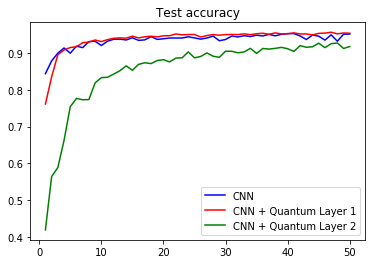

In [53]:
import matplotlib.pyplot as plt

acc1 = history1['val_acc']
acc2 = history3['val_acc']
acc3 = history2['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'b', label='CNN')
plt.plot(epochs, acc3, 'r', label='CNN + Quantum Layer 1')
plt.plot(epochs, acc2, 'g', label='CNN + Quantum Layer 2')
plt.title('Test accuracy')
plt.legend()

plt.show()

## QUANVOLUTIONAL NEURAL NETWORK

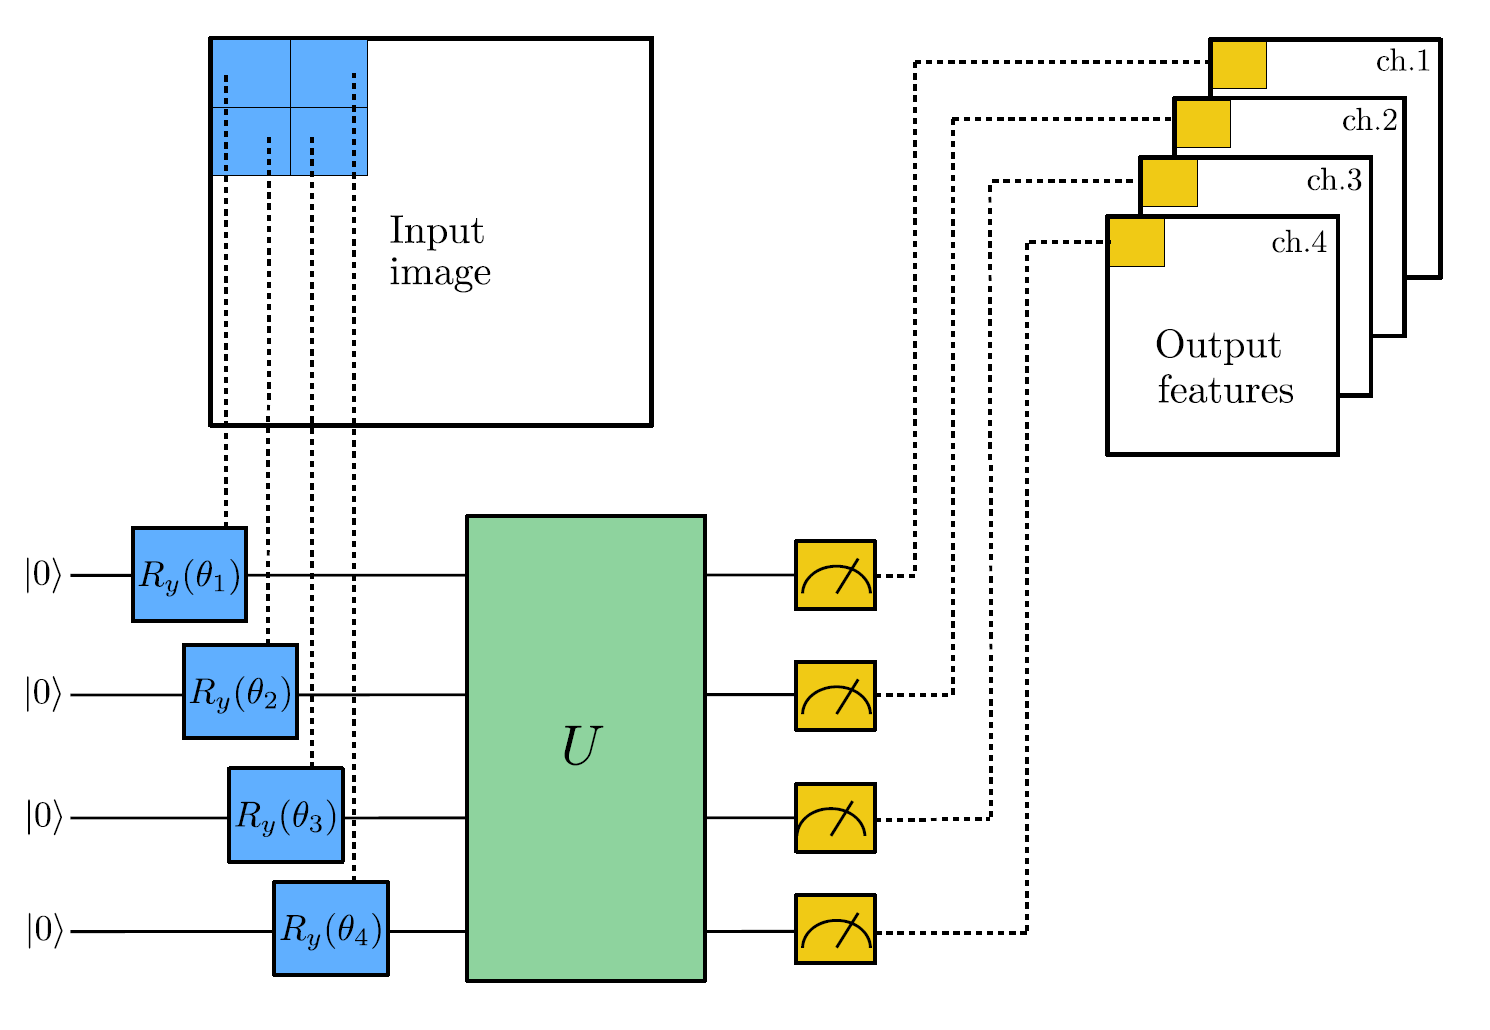

## IMPLEMENTATION 

In [60]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend):
        # --- Circuit definition start ---
        
        self.n_qubits = kernel_size ** 2
        all_qubits = [i for i in range(self.n_qubits)]
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.ry(self.theta[i], all_qubits[i])
        
        self._circuit.barrier()
        self._circuit = self._circuit.compose(random_circuit(self.n_qubits, 2))
        self._circuit.measure_all()
        self._circuit = transpile(self._circuit, backend)
        
        # ---- Circuit definition end ----

        self.backend   = backend

        
    def encoding(self, zone):
        thetas = []
        for pixel in zone[0]:
            thetas.append(np.pi*pixel.item())
        return thetas

    def random_quantum_circuit(self, thetas):
        qc = self._circuit
        para = [{self.theta[i]: theta for i,theta in zip(range(self.n_qubits), thetas)}]
        qobj = assemble(qc, shots=100, parameter_binds = para)
        job = self.backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        return counts

    def decoding(self, counts):
        L = list(counts.values())
        T = list(counts.keys())
        r = []
        for i in range(len(T[0])):
            s = 0
            for j in range(len(T)):
                s += int(T[j][i])*L[j]
            r.append(s)
        
        return torch.FloatTensor(r)


    def run(self, zone):
        zone = torch.reshape(zone, (1, self.n_qubits))
        init = self.encoding(zone)
        result = self.random_quantum_circuit(init)
        dec = self.decoding(result)
        return dec

In [198]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        width, length = inputs[0][0].size()
        width = width - kernel_size + 1
        length = length - kernel_size + 1
        
        outputs = torch.zeros((len(inputs), kernel_size**2*len(quantum_circuits), width, length))
        for i in range(len(inputs)):
            input = inputs[i]
            for c in range(len(quantum_circuits)):
                circuit = quantum_circuits[c]
                for h in range(length):
                    for w in range(width):
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c:c+kernel_size**2, h, w] = circuit.run(data)

        ctx.save_for_backward(inputs, outputs) 
        return outputs

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        
        gradients = torch.tensor([gradients])
        gradients = torch.transpose(gradients, 0, 1)

        return gradients.float() * grad_output.float(), None, None
    
class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, nb_filters, kernel_size, backend =qiskit.Aer.get_backend('aer_simulator'), shift=np.pi/2):
        super(Quanv, self).__init__()
        
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, backend=backend) for i in range(nb_filters)]
        self.kernel_size  = kernel_size
        self.shift        = shift
        
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.kernel_size, self.quantum_circuits, self.shift)

In [199]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(nb_filters=1, kernel_size = 2) 
        self.conv1 = nn.Conv2d(4, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.quanv(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
m = Net()
summary(m, (1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             Quanv-1            [-1, 4, 27, 27]               0
            Conv2d-2            [-1, 6, 23, 23]             606
            Conv2d-3             [-1, 16, 7, 7]           2,416
         Dropout2d-4             [-1, 16, 3, 3]               0
            Linear-5                   [-1, 64]           9,280
            Linear-6                   [-1, 10]             650
Total params: 12,952
Trainable params: 12,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.05
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


## USING A DICTIONARY TO SPEED UP THE EXECUTION

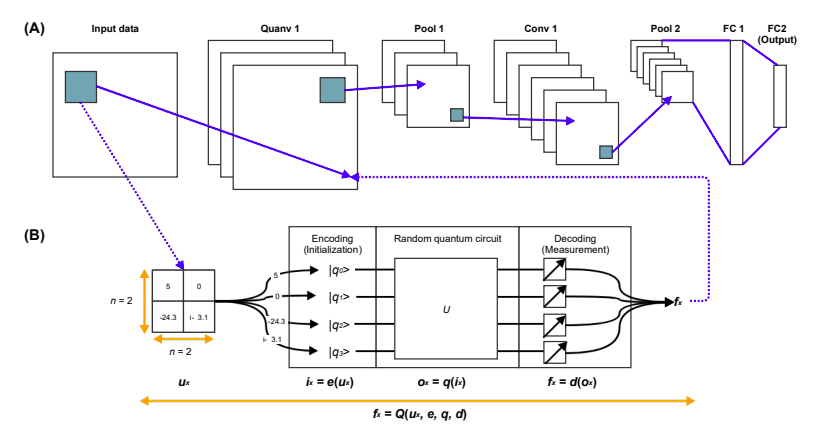

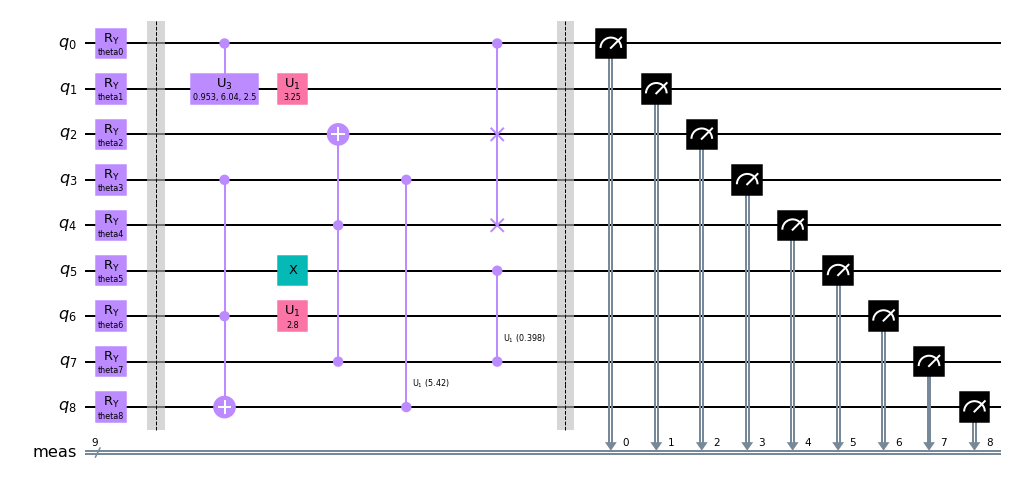

In [75]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, result = dict()):
        # --- Circuit definition start ---
        
        self.n_qubits = kernel_size ** 2
        all_qubits = [i for i in range(self.n_qubits)]
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.ry(self.theta[i], all_qubits[i])
        
        self._circuit.barrier()
        self._circuit = self._circuit.compose(random_circuit(self.n_qubits, 2))
        self._circuit.measure_all()
        self._circuit = transpile(self._circuit, backend)
        
        # ---- Circuit definition end ----
        self.result = result
        self.backend   = backend
    
        
    def encoding(self, zone):
        thetas = []
        for pixel in zone[0]:
            if pixel.item() > 0.5:
                thetas.append(np.pi) # etat |1>, on initialise theta à pi                      
            else:                    # pour faire une rotation d'angle pi de l'etat |0>
                thetas.append(0.0)     # etat |0>, on initialise theta à 0 (rester à l'etat |0>)
        return thetas


    def run(self, zone):
        zone = torch.reshape(zone, (1, self.n_qubits))
        init = str(self.encoding(zone))
        result = self.result[init]
        return result
x =  QuanvCircuit(3, backend = Aer.get_backend('aer_simulator'))
x._circuit.draw(output='mpl')

In [76]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        width, length = inputs[0][0].size()
        width = width - kernel_size + 1
        length = length - kernel_size + 1
        
        outputs = torch.zeros((len(inputs), len(quantum_circuits), width, length))

        for h in range(length):
            for w in range(width):
                for c in range(len(quantum_circuits)):
                    circuit = quantum_circuits[c]
                    for i in range(len(inputs)):
                        input = inputs[i]
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c, h, w] = circuit.run(data)

        ctx.save_for_backward(inputs, outputs) 
        return outputs
    # pas besoin du backward
    
class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, nb_filters, kernel_size, backend =qiskit.Aer.get_backend('aer_simulator'), shift=np.pi/2):
        super(Quanv, self).__init__()
        
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, backend=backend) for i in range(nb_filters)]
        self.kernel_size  = kernel_size
        self.shift        = shift
        self.nb_filters = nb_filters
        self.backend = backend
        self.update()
        
    def update(self):
        L = [[a*np.pi,b*np.pi,c*np.pi,d*np.pi, e*np.pi, f*np.pi,g*np.pi,h*np.pi,i*np.pi] for a in range(2) for b in range(2) for c in range(2) for d in range(2) for e in range(2) for f in range(2) for g in range(2) for h in range(2) for i in range(2)]
        for c in range(self.nb_filters):
            circuit = self.quantum_circuits[c]
            t = dict()
            for l in L:
                para = [{circuit.theta[i]: theta for i,theta in zip(range(self.kernel_size**2), l)}]
                qobj = assemble(circuit._circuit, shots=1000, parameter_binds = para)
                job = self.backend.run(qobj)
                result = job.result()
                counts = result.get_counts()
                i=np.argmax(list(counts.values()))
                t[str(l)] = sum([int(m) for m in list(counts.keys())[i]])
            circuit.result = t
            
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.kernel_size, self.quantum_circuits, self.shift)

In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(nb_filters=1, kernel_size = 3) 
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.quanv(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
model4 = Net()
optimizer  = optim.Adam(model4.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [78]:
history4 = train(
    model = model4,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=50)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=50, device=cpu

Epoch   1/ 50, train loss:  1.68, train acc:  0.42, val loss:  0.92, val acc:  0.71
Epoch   2/ 50, train loss:  0.86, train acc:  0.73, val loss:  0.62, val acc:  0.80
Epoch   3/ 50, train loss:  0.63, train acc:  0.82, val loss:  0.48, val acc:  0.85
Epoch   4/ 50, train loss:  0.57, train acc:  0.82, val loss:  0.44, val acc:  0.86
Epoch   5/ 50, train loss:  0.49, train acc:  0.85, val loss:  0.42, val acc:  0.87
Epoch   6/ 50, train loss:  0.43, train acc:  0.87, val loss:  0.35, val acc:  0.89
Epoch   7/ 50, train loss:  0.41, train acc:  0.88, val loss:  0.37, val acc:  0.88
Epoch   8/ 50, train loss:  0.38, train acc:  0.88, val loss:  0.33, val acc:  0.90
Epoch   9/ 50, train loss:  0.35, train acc:  0.90, val loss:  0.30, val acc:  0.91
Epoch  10/ 50, train loss:  0.33, train acc:  0.90, val loss:  0.29, val acc:  0.91
Epoch  11/ 50, train loss:  0.29, train acc:  0.91, val loss:  0.30, val acc:  0.91
Epo

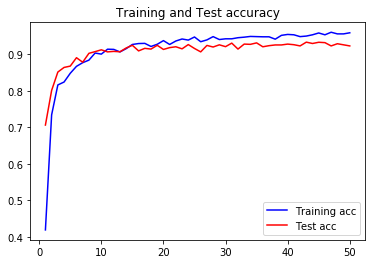

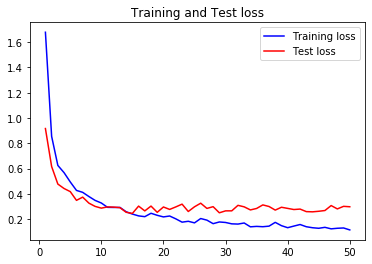

In [79]:
import matplotlib.pyplot as plt

acc = history4['acc']
val_acc = history4['val_acc']
loss = history4['loss']
val_loss = history4['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## COMPARING TO CNN

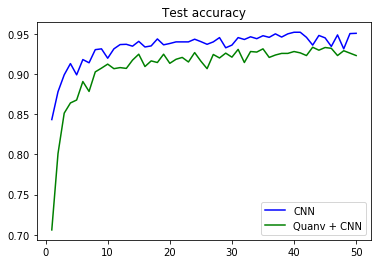

In [80]:
import matplotlib.pyplot as plt

acc1 = history1['val_acc']
acc2 = history4['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'b', label='CNN')
plt.plot(epochs, acc2, 'g', label='Quanv + CNN')
plt.title('Test accuracy')
plt.legend()
plt.show()

## EFFECT OF THE NUMBER OF FILTERS

In [104]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, result = dict()):
        # --- Circuit definition start ---
        
        self.n_qubits = kernel_size ** 2
        all_qubits = [i for i in range(self.n_qubits)]
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.ry(self.theta[i], all_qubits[i])
        
        self._circuit.barrier()
        self._circuit = self._circuit.compose(random_circuit(self.n_qubits, 2))

        self._circuit.measure_all()
        self._circuit = transpile(self._circuit, backend)
        
        # ---- Circuit definition end ----
        self.result = result
        self.backend   = backend
    
        
    def encoding(self, zone):
        thetas = []
        for pixel in zone[0]:
            if pixel.item() > 0.5:
                thetas.append(np.pi) # etat |1>, on initialise theta à pi                      
            else:                    # pour faire une rotation d'angle pi de l'etat |0>
                thetas.append(0.0)     # etat |0>, on initialise theta à 0 (rester à l'etat |0>)
        return thetas


    def run(self, zone):
        zone = torch.reshape(zone, (1, self.n_qubits))
        init = str(self.encoding(zone))
        result = self.result[init]
        return result


In [94]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        width, length = inputs[0][0].size()
        width = width - kernel_size + 1
        length = length - kernel_size + 1
        
        outputs = torch.zeros((len(inputs), len(quantum_circuits), width, length))

        for h in range(length):
            for w in range(width):
                for c in range(len(quantum_circuits)):
                    circuit = quantum_circuits[c]
                    for i in range(len(inputs)):
                        input = inputs[i]
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c, h, w] = circuit.run(data)

        ctx.save_for_backward(inputs, outputs) 
        return outputs
    # pas besoin du backward
    
class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, nb_filters, kernel_size, backend =qiskit.Aer.get_backend('aer_simulator'), shift=np.pi/2):
        super(Quanv, self).__init__()
        
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, backend=backend) for i in range(nb_filters)]
        self.kernel_size  = kernel_size
        self.shift        = shift
        self.nb_filters = nb_filters
        self.backend = backend
        self.update()
        
    def update(self):
        L = [[a*np.pi,b*np.pi,c*np.pi,d*np.pi, e*np.pi, f*np.pi,g*np.pi,h*np.pi,i*np.pi] for a in range(2) for b in range(2) for c in range(2) for d in range(2) for e in range(2) for f in range(2) for g in range(2) for h in range(2) for i in range(2)]
        for c in range(self.nb_filters):
            circuit = self.quantum_circuits[c]
            t = dict()
            for l in L:
                para = [{circuit.theta[i]: theta for i,theta in zip(range(self.kernel_size**2), l)}]
                qobj = assemble(circuit._circuit, shots=1000, parameter_binds = para)
                job = self.backend.run(qobj)
                result = job.result()
                counts = result.get_counts()
                i=np.argmax(list(counts.values()))
                t[str(l)] = sum([int(m) for m in list(counts.keys())[i]])
            circuit.result = t
            
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.kernel_size, self.quantum_circuits, self.shift)

In [95]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(nb_filters=5, kernel_size = 3) 
        self.conv1 = nn.Conv2d(5, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.quanv(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
model6 = Net()
optimizer  = optim.Adam(model6.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [96]:
history6 = train(
    model = model6,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=50)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=50, device=cpu

Epoch   1/ 50, train loss:  1.45, train acc:  0.51, val loss:  0.66, val acc:  0.81
Epoch   2/ 50, train loss:  0.62, train acc:  0.82, val loss:  0.45, val acc:  0.87
Epoch   3/ 50, train loss:  0.49, train acc:  0.85, val loss:  0.37, val acc:  0.89
Epoch   4/ 50, train loss:  0.40, train acc:  0.89, val loss:  0.32, val acc:  0.91
Epoch   5/ 50, train loss:  0.36, train acc:  0.89, val loss:  0.30, val acc:  0.90
Epoch   6/ 50, train loss:  0.34, train acc:  0.90, val loss:  0.30, val acc:  0.91
Epoch   7/ 50, train loss:  0.31, train acc:  0.90, val loss:  0.30, val acc:  0.90
Epoch   8/ 50, train loss:  0.26, train acc:  0.91, val loss:  0.28, val acc:  0.92
Epoch   9/ 50, train loss:  0.29, train acc:  0.91, val loss:  0.29, val acc:  0.92
Epoch  10/ 50, train loss:  0.26, train acc:  0.92, val loss:  0.26, val acc:  0.92
Epoch  11/ 50, train loss:  0.25, train acc:  0.92, val loss:  0.25, val acc:  0.92
Epo

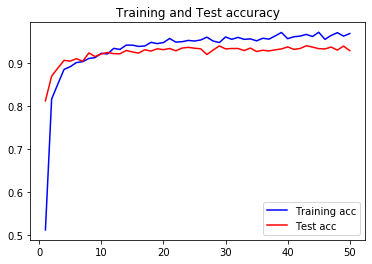

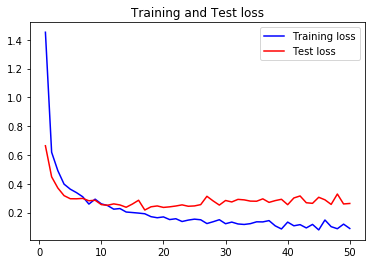

In [97]:
import matplotlib.pyplot as plt

acc = history6['acc']
val_acc = history6['val_acc']
loss = history6['loss']
val_loss = history6['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## 1 FILTER vs 5 FILTERS vs CNN

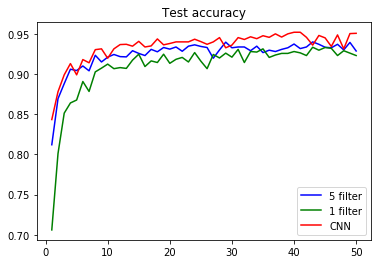

In [99]:
import matplotlib.pyplot as plt

acc1 = history6['val_acc']
acc2 = history4['val_acc']
acc3 = history1['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'b', label='5 filter')
plt.plot(epochs, acc2, 'g', label='1 filter')
plt.plot(epochs, acc3, 'r', label='CNN')

plt.title('Test accuracy')
plt.legend()
plt.show()

## CHANGING THE DECODING FUNCTION 

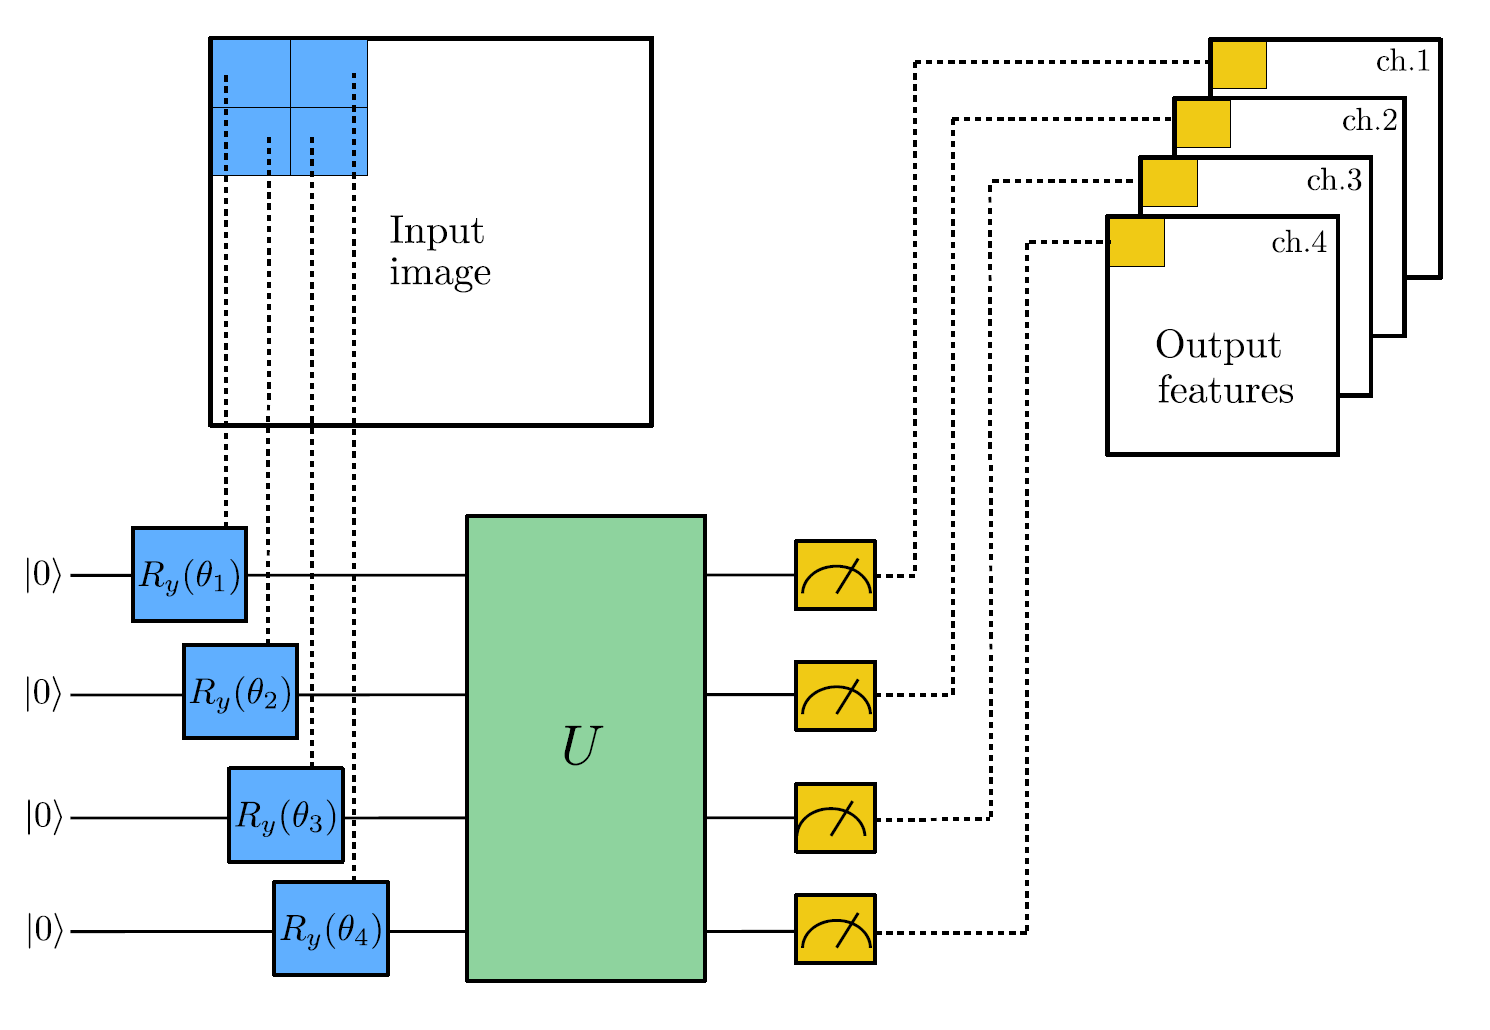

In [81]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, result = dict()):
        # --- Circuit definition start ---
        
        self.n_qubits = kernel_size ** 2
        all_qubits = [i for i in range(self.n_qubits)]
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.ry(self.theta[i], all_qubits[i])
        
        self._circuit.barrier()
        self._circuit = self._circuit.compose(random_circuit(self.n_qubits, 2))

        self._circuit.measure_all()
        self._circuit = transpile(self._circuit, backend)
        
        # ---- Circuit definition end ----
        self.result = result
        self.backend   = backend
    
        
    def encoding(self, zone):
        thetas = []
        for pixel in zone[0]:
            if pixel.item() > 0.5:
                thetas.append(np.pi) # etat |1>, on initialise theta à pi                      
            else:                    # pour faire une rotation d'angle pi de l'etat |0>
                thetas.append(0.0)     # etat |0>, on initialise theta à 0 (rester à l'etat |0>)
        return thetas


    def run(self, zone):
        zone = torch.reshape(zone, (1, self.n_qubits))
        init = str(self.encoding(zone))
        result = self.result[init]
        return result

In [82]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        width, length = inputs[0][0].size()
        width = width - kernel_size + 1
        length = length - kernel_size + 1
        
        outputs = torch.zeros((len(inputs), kernel_size**2*len(quantum_circuits), width, length))
        for i in range(len(inputs)):
            input = inputs[i]
            for c in range(len(quantum_circuits)):
                circuit = quantum_circuits[c]
                for h in range(length):
                    for w in range(width):
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c:c+kernel_size**2, h, w] = circuit.run(data)

        ctx.save_for_backward(inputs, outputs) 
        return outputs

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        
        gradients = torch.tensor([gradients])
        gradients = torch.transpose(gradients, 0, 1)

        return gradients.float() * grad_output.float(), None, None
    
class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, nb_filters, kernel_size, backend =qiskit.Aer.get_backend('aer_simulator'), shift=np.pi/2):
        super(Quanv, self).__init__()
        
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, backend=backend) for i in range(nb_filters)]
        self.kernel_size  = kernel_size
        self.shift        = shift
        self.nb_filters = nb_filters
        self.backend = backend
        self.update()
        
    def update(self):
        L = [[a*np.pi,b*np.pi,c*np.pi,d*np.pi, e*np.pi, f*np.pi,g*np.pi,h*np.pi,i*np.pi] for a in range(2) for b in range(2) for c in range(2) for d in range(2) for e in range(2) for f in range(2) for g in range(2) for h in range(2) for i in range(2)]
        for c in range(self.nb_filters):
            circuit = self.quantum_circuits[c]
            t = dict()
            for l in L:
                para = [{circuit.theta[i]: theta for i,theta in zip(range(self.kernel_size**2), l)}]
                qobj = assemble(circuit._circuit, shots=100, parameter_binds = para)
                job = self.backend.run(qobj)
                result = job.result()
                counts = result.get_counts()
                J = list(counts.values())
                T = list(counts.keys())
                r = []
                for i in range(len(T[0])):
                    s = 0
                    for j in range(len(T)):
                        s += int(T[j][i])*J[j]
                    r.append(s)
                t[str(l)] = torch.FloatTensor(r)
            circuit.result = t
            
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.kernel_size, self.quantum_circuits, self.shift)

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(nb_filters=1, kernel_size = 3) 
        self.conv1 = nn.Conv2d(9, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.quanv(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
model5 = Net()
optimizer  = optim.Adam(model5.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [86]:
history5 = train(
    model = model5,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=50)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=50, device=cpu

Epoch   1/ 50, train loss:  1.83, train acc:  0.44, val loss:  0.74, val acc:  0.78
Epoch   2/ 50, train loss:  0.78, train acc:  0.75, val loss:  0.51, val acc:  0.84
Epoch   3/ 50, train loss:  0.60, train acc:  0.81, val loss:  0.50, val acc:  0.85
Epoch   4/ 50, train loss:  0.50, train acc:  0.85, val loss:  0.35, val acc:  0.89
Epoch   5/ 50, train loss:  0.44, train acc:  0.86, val loss:  0.33, val acc:  0.90
Epoch   6/ 50, train loss:  0.39, train acc:  0.89, val loss:  0.41, val acc:  0.88
Epoch   7/ 50, train loss:  0.35, train acc:  0.90, val loss:  0.32, val acc:  0.90
Epoch   8/ 50, train loss:  0.35, train acc:  0.90, val loss:  0.30, val acc:  0.91
Epoch   9/ 50, train loss:  0.32, train acc:  0.90, val loss:  0.31, val acc:  0.91
Epoch  10/ 50, train loss:  0.33, train acc:  0.90, val loss:  0.29, val acc:  0.91
Epoch  11/ 50, train loss:  0.30, train acc:  0.92, val loss:  0.29, val acc:  0.91
Epo

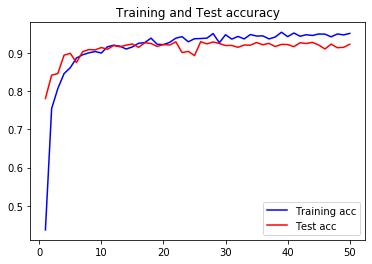

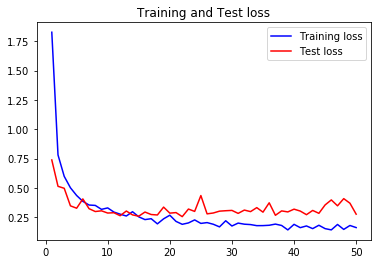

In [87]:
import matplotlib.pyplot as plt

acc = history5['acc']
val_acc = history5['val_acc']
loss = history5['loss']
val_loss = history5['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## DECODING 1 vs DECODING 2

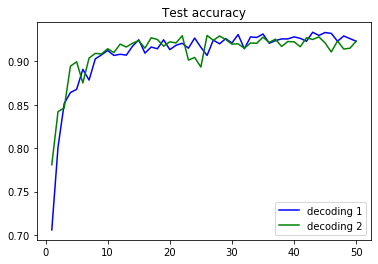

In [92]:
import matplotlib.pyplot as plt

acc1 = history5['val_acc']
acc2 = history4['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc2, 'b', label='decoding 1')
plt.plot(epochs, acc1, 'g', label='decoding 2')
plt.title('Test accuracy')
plt.legend()
plt.show()